Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [2]:
NAME = "Victor Miguel Velazquez Espitia"
ID_number = int("2043179")
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# Classification on Wine Dataset

### Dataset description

We will be working with a dataset on wines from the UCI machine learning repository
(http://archive.ics.uci.edu/ml/datasets/Wine ). It contains data for 178 instances. 
The dataset is the results of a chemical analysis of wines grown in the same region
in Italy but derived from three different cultivars. The analysis determined the
quantities of 13 constituents found in each of the three types of wines. 

### The features in the dataset are:

- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
-Proline




We first import all the packages that are needed

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
import copy

In [4]:
np.random.seed(ID_number)

# Perceptron
We will implement the perceptron and use it to learn a halfspace with 0-1 loss.

Load the dataset from scikit learn and then split in training set and test set (50%-50%) after applying a random permutation to the dataset.

In [5]:
# Load the dataset from scikit learn
wine = datasets.load_wine()
# Get input and output data from the dataset
X = wine.data
Y = wine.target
# Create new labels
Y = np.where(Y == 0, -1, Y)
Y = np.where(Y == 2, -1, Y)
# Let's get the number of features
d = X.shape[1]

In [7]:
##### Helper functions, do not modify them. You will need them for the first TODO
def check_constraints(labels, all_possibile_labels, min_num_istances):
    # Count the number of occurrences using numpy
    unique, counts = np.unique(labels, return_counts=True)
    if len(all_possibile_labels) != len(unique):
        return True
    if (counts >= min_num_istances).all():
        return False
    else:
        return True
    
def need_new_shuffle(y_train, y_test, all_possibile_labels, min_num_istances): 
    return (check_constraints(y_train, all_possibile_labels, min_num_istances) or 
            check_constraints(y_test, all_possibile_labels, min_num_istances))

In [8]:
# TODO 1
# Write a function (create_train_val_test_datasets) which takes as input a dataset and returns 2 datasets: 
# S_t and S_test (different runs are supposed) to return different datasets.
# Write a function (create_train_val_test_datasets_with_constraints) which splits our data in S_t and S_test with 
# the additional constraint that in each dataset we MUST have more than min_num_istances per class.
# Each dataset is represented as a matrix m \times d (numpy ndarray), where m is the number of data and d is the 
# number of features.
# To solve this TODO use the functions we provide you: check_constraints and need_new_shuffle

def create_train_val_test_datasets(features : np.ndarray, labels: np.ndarray, m_t : int, m_test : int):
    '''
    Create training (S_t) and test (S_test) sets starting from a dataset. 
    This function shuffles the complete dataset before creating the subsets. 
    If you call this function twice it is expected to get different S_t, S_test. 
    
    :param features: NumPy ndarray containing all the input data data we can use
    :param labels: NumPy ndarray containing all the labels we have
    :param m_t: Number of samples for the training dataset
    :param m_test: Number of samples for the test dataset
    
    :returns: (x_train, y_train, x_test, y_test)
    :rtype: tuple
        WHERE
        x_train : np.ndarray features in the training dataset
        y_train : np.ndarray labels in the training dataset
        x_test : np.ndarray features in the test dataset
        y_test : np.ndarray labels in the test dataset
    '''
    # SUGGESTION: Use the function np.random.permutation (see the documentation) to create a permutation of the 
    #             dataset indexes. Then use these shuffled indexes to create S_t, S_val, S_test
    # YOUR CODE HERE
    data = np.c_[features, labels]                          #put features and labels in same numpy array
    data = np.random.permutation(data)                      #Make the permutation of the data
    labels = data.T[features.shape[1]]                      #get the new labels
    features = np.delete(data, features.shape[1], axis = 1) #delete the labels so we keep the features
    S_t_features=features[0:m_t]                            #Divide between the training and test for both features and labels
    S_test_features=features[m_t:m_t+m_test]
    S_t_labels=labels[0:m_t]
    S_test_labels=labels[m_t:m_t+m_test]

    x_train = S_t_features[:,:]                             #Set it as X and Y data i.e features and labels with proper dimension
    x_test  = S_test_features[:,:]
    y_train = S_t_labels[:].reshape(-1,1)
    y_test  = S_test_labels[:].reshape(-1,1)
    return x_train, y_train, x_test, y_test


def create_train_val_test_datasets_with_constraints(features : np.ndarray, labels: np.ndarray, m_t : int, 
                                                    m_test : int, min_num_istances : int):
    '''
    Same as function above but now we are imposing the constraints: the splitted datasets are assumed to contain 
    at least min_num_istances per class.
    
    ...
    :param min_num_istances: Minimum number of istances per class in each of the splitted datasets
    ...
    
    '''
    all_possibile_labels = np.unique(labels)                                #get the labels 
    #YOUR CODE HERE

    data = np.c_[features, labels]
    data = np.random.permutation(data)
    labels = data.T[features.shape[1]]
    features = np.delete(data, features.shape[1], axis = 1)
    x_train=features[0:m_t]
    x_test=features[m_t:m_t+m_test]
    y_train=labels[0:m_t].reshape(-1,1)
    y_test=labels[m_t:m_t+m_test].reshape(-1,1)

    #Do the contraint
    #Keep shuffling until min number of instance satisfied for each parameter
    while need_new_shuffle(y_train, y_test, all_possibile_labels,min_num_istances) == True:  
        data = np.c_[features, labels]
        data = np.random.permutation(data)
        labels = data.T[features.shape[1]]
        features = np.delete(data, features.shape[1], axis = 1)
        x_train=features[0:m_t]
        x_test=features[m_t:m_t+m_test]
        y_train=labels[0:m_t].reshape(-1,1)
        y_test=labels[m_t:m_t+m_test].reshape(-1,1)

    return x_train, y_train, x_test, y_test

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

In [7]:
assert x_train.shape == (m_t,       x_train.shape[1]) # here we are comparing two tuples (it is an element wise comparison)
assert x_test.shape  == (len(Y)-m_t, x_test.shape[1])

In [8]:
# Let's add a 1 in front of each sample so that we can use a vector to describe all the coefficients of the model.
# Do not run this cell multiple times otherwise you will continue adding ones... 
# (we add the assert to avoid such issue)

assert x_train.shape[1] == d
assert x_test.shape[1] == d 

x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))

**TO DO 2** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where 1 iteration corresponds to 1 update of the perceptron weights. If the perceptron returns because the maximum number of iterations has been reached, you should return an appropriate model (the best seen along the iterations). 

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of missclassified samples for the best model
- $w\_iters$: a list of the coefficients found by the algorithm, in those iterations in which the error decreases. This is an 'auxiliary output' (it is not needed for the actual algorithm) that will allows us to have a better insight on the algorithm's behaviour
- $error\_iters$: a list of the *fractions* of missclassified samples for every model found through the same iterations as for the list above. Again an auxiliary output.


**Auxiliary functions**

In order to correclty complete the perceptron function it is warmly recommended to define some auxiliary functions ("*find_missclassified*" and "*choose_missclassified*"). 


"__find_missclassified__"
This function looks for missclassified data points in the dataset $X$.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $curr\_w$: the current value of the parameter vector *w*

The output value is:
- $missclassified\_indeces$: a numpy array cointaining all the missclassified indeces  


"__choose_missclassified__"
This function return one single index choosen from a array of indeces. If the array is empty it returns a non valid index: -1. 

The input parameters to pass are:
- $missclassified\_indeces$: numpy arrya containing missclassified indeces

The output value is:
- $index$: Integer (or np.int64) containing the choosen index


In [9]:
# TODO 2

def find_missclassified(X,Y,curr_w):
    # Here you can use np.argwhere to find which model predictions are correct (this is faster than a for loop)
    # but be carefull on the dimensions of your predictions vector and Y vector.
    # YOUR CODE HERE
    a = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        a[i]=Y[i]*np.matmul(curr_w, X[i,:].reshape(-1,1))
    missclassified_indeces = np.argwhere(a<=0)
    return missclassified_indeces.reshape(-1,)

def choose_missclassified(missclassified_indeces):
    # YOUR CODE HERE
    #raise NotImplementedError() # Remove this line
    if len(missclassified_indeces) == 0:
        index = -1
    else:
        index = np.random.choice(missclassified_indeces)   
    return index

def perceptron(X,Y,max_num_iterations):
    #INITIALIZATION
    curr_w = np.zeros(X.shape[1])   #row vector
    best_w = curr_w
    num_samples = X.shape[0]
    best_error = num_samples+1  # max + 1 number of possible errors 
    w_iters = []                #matrix 178x13
    error_iters = [] 
    
    missclassified_indeces = find_missclassified(X,Y,curr_w)  # You need to assign this variable the proper value
    num_missclassified = len(missclassified_indeces)       # You need to assign this variable the proper value
    index_missclassified = choose_missclassified(missclassified_indeces)     # You need to assign this variable the proper value
    
    # YOUR CODE HERE
    num_iter = 1  
    while index_missclassified != -1 and num_iter < max_num_iterations: # Remove this False and pass and place the right termination conditionS
        # Update rule
        #YOUR CODE HERE 
        curr_w = curr_w+(Y[index_missclassified]*X[index_missclassified,:])

        # Update missclassified data points and choose a new missclassified data point
        # YOUR CODE HERE
        
        missclassified_indeces = find_missclassified(X,Y,curr_w)  # You need to assign this variable the proper value
        num_missclassified = len(missclassified_indeces)       # You need to assign this variable the proper value
        index_missclassified = choose_missclassified(missclassified_indeces)
        #raise NotImplementedError() # Remove this line
        # Update (if necessary) the best error achieved together with the best parameter up to now. 
        # Use copy.copy(curr_w) to copy your current w on "best_w" (since these are arrays you would be copying 
        # only the pointer if you do not use copy.copy) and to append your current w to the list of all w found so far
        # Append the current error to the list of all errors found so far
        # YOUR CODE HERE
        
        if  num_missclassified < best_error:
            w_iters.append(curr_w)
            error_iters.append(num_missclassified)
            best_w = copy.copy(curr_w)
            best_error = num_missclassified
        num_iter = num_iter+1   

    best_error = float(best_error)/float(num_samples)
    return best_w, best_error, w_iters, error_iters

In [10]:
index = choose_missclassified(np.array(list(range(100))))
assert type(index) == np.int64 or type(index) == int or type(index) == np.int32


In [11]:
# Now run the perceptron for 100 iterations
# We want just to see the output of the algorithm, so we can avoid assigning the auxiliary outputs to actual variables
w_found, training_error, _, _ = perceptron(x_train, y_train, 100)
print("Training error with 100 iterations: " + str(training_error))

Training error with 100 iterations: 0.2875


In [12]:
# TODO 3 
# Write a function to compute the fraction of missclassified samples given two nd.array vectors of shape number of 
# data times 1 (column vectors)
def classification_loss(y_target : np.ndarray, predictions : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples given two vectors: true labels and predictions. 
    :param y_target: output labels
    :param predictions: predictions
    
    :return: Fraction of missclassified samples
    '''
    # YOUR CODE HERE
    error = np.zeros(len(y_target))
    for i in range(len(y_target)):
        if y_target[i]!=predictions[i]:
            error[i] = 1                            #put 1 where there is a mismatch
    missclassified_indeces = np.argwhere(error==1)
    
    #raise NotImplementedError() # Remove this line
    return missclassified_indeces.shape[0] / y_target.shape[0]

# Write a function to comptue the fraction of missclassified samples for a generic dataset given inputs, targets and 
# a vector w.
def compute_fraction_missclassified(X : np.ndarray, Y : np.ndarray, w : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples of model parametrized by w on the data X w.r.t. 
    targets Y. 
    :param X: input locations
    :param Y: targets
    :param w: parameters of the model to be tested
    
    :return: Fraction of missclassified samples
    '''
    # YOUR CODE HERE
    a = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        a[i]=Y[i]*np.matmul(w, X[i].reshape(-1,1))
    missclassified_indeces = np.argwhere(a<=0)
    fraction_missclass = len(missclassified_indeces)/len(Y)
    
    #raise NotImplementedError() # Remove this line
    return fraction_missclass

In [13]:
assert classification_loss(np.array([[1],[3]]), np.array([[1],[3]])) == 0
assert classification_loss(np.array([[1],[2]]), np.array([[1],[3]])) == 0.5
y_labels, y_predictions = np.random.choice(10, 1000000), np.random.choice(10, 1000000)
assert np.isclose(classification_loss(y_labels, y_predictions), 0.9, atol=0.01)
assert training_error == compute_fraction_missclassified(x_train, y_train, w_found)


We now use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of missclassified samples in the test set (that is an estimate of the true loss).

In [14]:
print(f"Training Error for 100 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 100 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 100 iterations is 0.2875
Test Error for 100 iterations is 0.2347


In [15]:
# now run the perceptron for 10000 iterations
# This time we assign also the auxiliary outputs! They will be useful later on!
w_found, training_error, w_list, error_list_train = perceptron(x_train, y_train, 10000)
print(f"Training Error for 10000 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 10000 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 10000 iterations is 0.2000
Test Error for 10000 iterations is 0.2143


**TO DO 4**: Answer in the next cell (you do not need more than 5-7 lines):

1- Consider 100 iterations: what relation do you observe between the training error and the (estimated) true loss? Is this what you expected? Explain what you observe and why it does or does not conform to your expectations.

2- Consider 10000 iterations, what has changed? Explain what you observe and why it does or does not conform to your expectations.

YOUR ANSWER HERE

In [16]:
#(1)Considering the 100 iteration, it is possible to observe that the training error is greater then the estimated loss. It 
#does not coincide with my expectations, in fact, usully, the training error is smaller that the estimated loss because
#it is evaluated on the same set using for determing the model. However, there could be some cases in which the model
#fits better with the data of the training set; it depends by the choice of data set. 
#, if both training and test error come from the same distributions, then,
#  is clear to say that achieving 0.2 in training doesnt mean i reached the best possible w,
#  otherwise, training and test errors would be the same.
#(2)In the second case (number of iterations equal to 100000) it is possibile to observe that the training error is 
#smaller than the test error, as I expect because the training error is evaluted over the same data
#set using for evalute the model. Moreover, both the training error and the test error descrease. It is what I expect: 
#More iterations are unnecesary and, because is relatively close to the true error, we can assume its satisfactoy,
#  although this might differ with requirements, other algorithms would achieve better performance.

**TO DO 5**: We want to have a better understanding of the hidden behaviour of perceptron algorithm. We indeed defined two auxiliary outputs that should allow us to inspect the training process in more depth. In particular, we want to check if the sequence of models' errors found through the different iterations is characterized by a decreasing trend, with respect to both training and test datasets.

The function `perceptron` already returns the sequence of errors, which is ready to be plotted. However, the errors for the test set aren not immediately available: we nonetheless have all different models, thus we can easily compute them! 

In [17]:
# TODO 5
# Write a function 'error_models' which takes as input a list of models (each of which is a numpy ndarray) and returns
# a list of corresponding errors for a generic dataset
# Suggestion: you can use 'compute_fraction_missclassified' from above to solve this TODO

def error_models(X : np.ndarray, Y : np.ndarray, w_l : list) -> list:
    '''
    This function computes the fraction of missclassified samples of model parametrized by w on the data X w.r.t. 
    targets Y. 
    :param X: input locations
    :param Y: targets
    :param w: list of arrays (models) to be tested
    
    :return: List of fraction of missclassified samples for each model
    '''
    errors = []
    # YOUR CODE HERE
    for i in range(len(w_l)):
        errors.append(compute_fraction_missclassified(X,Y,w_l[i]))
    return errors

In [18]:
assert len(error_models(x_test, y_test, w_list)) == len(error_list_train)
assert len(error_models(x_test, y_test, w_list)) <= 10000


In [19]:
# Let's make 'error_list_train' a fraction of the missclassified samples by dividing for the size of the training set
error_list_train = np.array(error_list_train)/x_train.shape[0]

Text(0.5, 1.0, 'Perceptron test error behaviour')

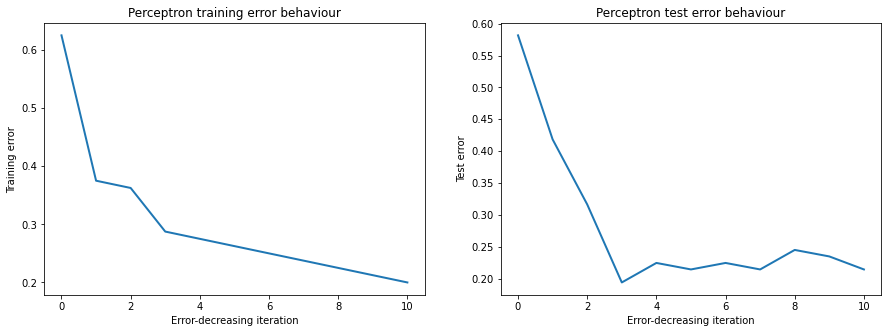

In [20]:
error_list_test = error_models(x_test, y_test, w_list)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot([i for i in range(len(w_list))], error_list_train, linewidth=2)
axes[0].set_xlabel('Error-decreasing iteration')
axes[0].set_ylabel('Training error')
axes[0].set_title('Perceptron training error behaviour')
axes[1].plot([i for i in range(len(w_list))], error_list_test, linewidth=2)
axes[1].set_xlabel('Error-decreasing iteration')
axes[1].set_ylabel('Test error')
axes[1].set_title('Perceptron test error behaviour')

**TO DO 6**: Answer in the next cell (you do not need more than 5-7 lines):

Consider the plot above. How do the two errors compare? Can you identify a particular property of one of them? Why doesn't the other have it?

YOUR ANSWER HERE

In [21]:
# The graph on the left, "Perceptron trainig error behaviour", describes the behaviour of the error as w
#changes, considering the w determined with the perceptron algorithm (defined in todo 2) for every iteration when 
#the numbers of error decreses. Therefore, as the model has been determined with respect to the training set, if 
#I apply it to the training set I expect that the w determined fits well with the reality and so the error decreses as
#it is shown in the first graph. On the other hand, if I apply the model determined with the trainig set to the test set
#I will expect to do more errors because the list of w are not determined with the test set. This is conformed with the
#graph on the left "Perceptron test error behaviour" that does not decrease for every w in w_list.
# In both we can percieve a similar correspondance, both tend to the decrease of the error.
#  It is remarkable that in the training set, the error its maintained in decreasing performance.
#  While the test error, founds first a local minimum, to then increase, and finally continue corresponding the expected behaviour. 
# This is because of the particular property,
#  that we cannot expect the same constant decreasing behaviour as in the training set, because of the simple reason, this is new data.

# Logistic Regression
Now we use logistic regression, as implemented in Scikit-learn, to predict labels. We first do it for 2 labels and then for 3 labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [22]:
import random
# Let's reinitialize the random seed 
random.seed(ID_number)
np.random.seed(ID_number)

# In the following we will keep the dataset with only two classes (which we aggregated before)
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5, max\_iter=?)$

$C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class. Choose the proper number of iterations: max_iter.

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it (have a look at the logreg.score method too).

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples missclassified in the training set and in the test set.

In [23]:
# TODO 7
# Logistic regression for 2 classes
# To compute the error rate (classification loss you can use the function "classification_loss" you built before)
max_iter = None
# YOUR CODE HERE
model_train = linear_model.LogisticRegression(C=1e5, max_iter = 10000).fit(x_train, np.ravel(y_train))
y_hat_train = model_train.predict(x_train)
y_hat_test = model_train.predict(x_test)
error_rate_training = classification_loss(y_train, y_hat_train)
error_rate_test = classification_loss(y_test, y_hat_test)
error_rate_test_sklearn = 1 - model_train.score(x_test, y_test)
#raise NotImplementedError() # Remove this line

print("Error rate on training set: "+str(error_rate_training))
print("Error rate on test set: "+str(error_rate_test))
print(f"Compare the estimate of generalization with the sklearn implementation {error_rate_test_sklearn}")

Error rate on training set: 0.0
Error rate on test set: 0.030612244897959183
Compare the estimate of generalization with the sklearn implementation 0.030612244897959218


In [24]:
assert np.isclose(error_rate_test, error_rate_test_sklearn)

Now we do logistic regression for classification with 3 classes.

In [25]:
random.seed(ID_number)
np.random.seed(ID_number)

X = wine.data
Y = wine.target

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

_, counts = np.unique(y_train, return_counts=True)
assert (counts >= 20).all()
_, counts = np.unique(y_test, return_counts=True)
assert (counts >= 20).all()

In [26]:
# TODO 8
# Logistic regression for 3 classes
# To compute the error rate (classification loss you can use the function "classification_loss" you built before)
# Choose the proper number of iterations: max_iter.
max_iter = None
# YOUR CODE HERE
model_train = linear_model.LogisticRegression(C=1e5, max_iter = 10000).fit(x_train, np.ravel(y_train))
y_hat_train = model_train.predict(x_train)
y_hat_test = model_train.predict(x_test)
error_rate_training = classification_loss(y_train, y_hat_train)
error_rate_test = classification_loss(y_test, y_hat_test)
error_rate_test_sklearn = 1 - model_train.score(x_test, y_test)
#raise NotImplementedError() # Remove this line    
print("Error rate on training set: "+str(error_rate_training))
print("Error rate on test set: "+str(error_rate_test))
print(f"Compare the estimate of generalization with the sklearn implementation {error_rate_test_sklearn}")

Error rate on training set: 0.0
Error rate on test set: 0.08163265306122448
Compare the estimate of generalization with the sklearn implementation 0.08163265306122447


In [27]:
assert np.isclose(error_rate_test, error_rate_test_sklearn)

**TO DO 9**: Answer in the next cell (you do not need more than 5-7 lines):

1- Consider logistic regression on 2 and 3 classes what relation do you observe between the training error and the (estimated) true loss in both cases? Is this what you expected? Explain what you observe and why it does or does not conform to your expectations.

2- Consider logistic regression on 2 and perceptron with 10000 iterations, which one would you pick? Do you expect perceptron needs more iterations? Explain what you observe and why it does or does not conform to your expectations.

YOUR ANSWER HERE

In [28]:
#(1) It is possible to observe that the training error is equal to zero while estimated loss based on the test set not.
#pointing the fact that in both cases the training error was less than the test error
#It is what I expected, in fact the the training error is compute over the set used to determine the model, therefore 
#I will expect a number of missclassified points very closed to zero. On the other hand while the estimated true loss 
#is computed using the model determined through the training set and applying it to a different set, the test set, 
#so I expect to compute a bigger number of errors.
#(2) I will pick the logistic regression algorithm because its estimate true loss is smaller. I expect that the perceptron 
#algorithm needs a huge number of iteration to compute a better estimation: it is possible to observe that increasing 
#the number of iteration from 100 to 10000 the estimate true loss decreases, so I expect that as the number of 
#iterations increases, the estimated true loss will continue to decrease.

We now are going to plot prediction boundaries of a logistic regression model, in order to plot them we need to reduce the number of features to 2: pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test.

In [29]:
# TODO 10
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                 'Proline']
labels_list = ['class_0', 'class_1', 'class_2']

index_feature1 = 0  # You can choose the feature you prefer here
index_feature2 = 1  # You can choose the feature you prefer here
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X = X[:,features]

# In the following we will keep the dataset with 3 classes
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)
# Fit a model on the reduced set of fetures
# YOUR CODE HERE
logreg = linear_model.LogisticRegression(C=1e5, max_iter = 10000).fit(x_train, np.ravel(y_train))
#raise NotImplementedError() # Remove this line

In [30]:
assert logreg.predict(x_test).shape == (x_test.shape[0], )

The code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

<ipython-input-31-a62ef003d687>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
<ipython-input-31-a62ef003d687>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


Text(0.5, 1.0, 'Test set')

<Figure size 288x216 with 0 Axes>

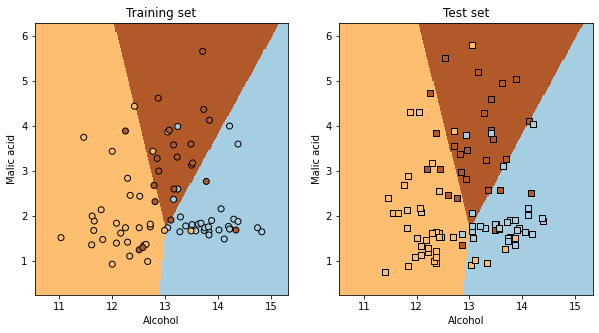

In [31]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
axes[0].set_xlabel(feature_name0)
axes[0].set_ylabel(feature_name1)

axes[0].set_xlim(xx.min(), xx.max())
axes[0].set_ylim(yy.min(), yy.max())
axes[0].set_title('Training set')

# Put the result into a color plot
Z = Z.reshape(xx.shape)
axes[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
axes[1].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
axes[1].set_xlabel(feature_name0)
axes[1].set_ylabel(feature_name1)

axes[1].set_xlim(xx.min(), xx.max())
axes[1].set_ylim(yy.min(), yy.max())
axes[1].set_title('Test set')

**TO DO 11**: Answer in the next cell (you do not need more than 5-7 lines):

1- What is the shape of the decision boundaries? Why?

2- In this lower dimensional space, are the features linearily separable? What if you consider the entire feature vector (without any dimensionality reduction)?  


YOUR ANSWER HERE

In [32]:
#(1)The shape of the decision boundaries are straight lines, becouse to be determined an linear classification algorithm
#has been used.
#(2)By the graphs, it is possible to see that the features are non linearly separable. If we consider the entire
#feature vector there could be a hyperplane capable of linearly separating all points.